<a href="https://colab.research.google.com/github/nadolsw/Python/blob/master/Dirty_Docs/Autoencoder_DDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#################################
#### CONNECT TO GOOGLE DRIVE ####
#################################
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [17]:
##########################
#### LIST DIRECTORIES ####
##########################
import glob
path = '/content/gdrive/My Drive/data/'
folders = [f for f in glob.glob(path + "**/", recursive=True)]
for f in folders:
    print(f)

/content/gdrive/My Drive/data/
/content/gdrive/My Drive/data/UCI HAR Dataset/
/content/gdrive/My Drive/data/UCI HAR Dataset/test/
/content/gdrive/My Drive/data/UCI HAR Dataset/test/Inertial Signals/
/content/gdrive/My Drive/data/UCI HAR Dataset/train/
/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/
/content/gdrive/My Drive/data/Stitched/
/content/gdrive/My Drive/data/Stitched/test/
/content/gdrive/My Drive/data/Stitched/test/sitting/
/content/gdrive/My Drive/data/Stitched/test/walking_upstairs/
/content/gdrive/My Drive/data/Stitched/test/walking/
/content/gdrive/My Drive/data/Stitched/test/walking_downstairs/
/content/gdrive/My Drive/data/Stitched/test/laying/
/content/gdrive/My Drive/data/Stitched/test/standing/
/content/gdrive/My Drive/data/Stitched/train/
/content/gdrive/My Drive/data/Stitched/train/standing/
/content/gdrive/My Drive/data/Stitched/train/walking/
/content/gdrive/My Drive/data/Stitched/train/sitting/
/content/gdrive/My Drive/data/Stitched/train/l

In [0]:
#%% #IMPORT NECESSARY PACKAGES

import os
import glob
import matplotlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import random
import scipy.ndimage

from scipy import signal
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array
from keras.models import Model
from keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Conv2D, LeakyReLU, ReLU, ELU
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from matplotlib.pylab import rcParams
from IPython.display import Image
rcParams['figure.figsize'] = 12, 4

In [0]:
#%% #SPECIFY DIRECTORY PATH

dirpath = '/content/gdrive/My Drive/data/Denoising_Dirty_Documents/'

TRAIN_IMAGES = glob.glob(dirpath + 'x_train/*.png')
CLEAN_IMAGES = glob.glob(dirpath + 'y_train/*.png')
TEST_IMAGES = glob.glob(dirpath + 'x_test/*.png')

print(len(TRAIN_IMAGES))
print(len(CLEAN_IMAGES))
print(len(TEST_IMAGES))

144
144
72


In [0]:
#%% #LOAD IMAGES

def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        image_list[i] = x
    
    return image_list

x_train = load_image(TRAIN_IMAGES)[:,:,:,0]
y_train = load_image(CLEAN_IMAGES)[:,:,:,0]
x_test = load_image(TEST_IMAGES)[:,:,:,0]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(144, 258, 540)
(144, 258, 540)
(72, 258, 540)


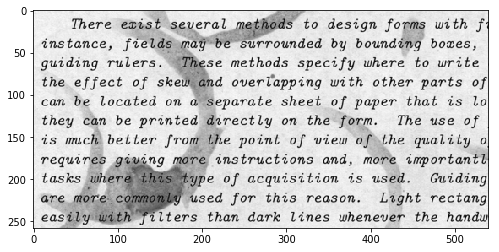

In [0]:
#%% #DISPLAY DIRTY IMAGE BEFORE ANY PROCESSING
plt.imshow(x_train[105], cmap = 'gray')

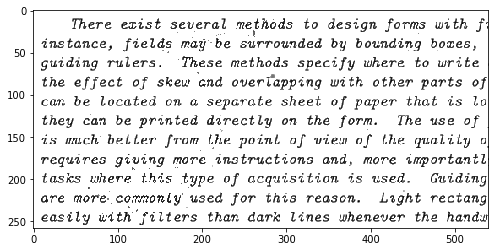

In [0]:
#%% #APPLY MEDIAN FILTERING

def denoise_image(inp):
    inp = inp/255.0
    # estimate 'background' color by a median filter
    bg = signal.medfilt2d(inp, 9)
    # compute 'foreground' mask as anything that is significantly darker than the background
    mask = inp < bg - 0.1
    # return the input value for all pixels in the mask or pure white otherwise
    return np.where(mask, inp, 1.0)

#x_train_median = np.array([denoise_image(img) for img in x_train])
#x_test_median = np.array([denoise_image(img) for img in x_test])
plt.imshow(x_train_median[105], cmap = 'gray')

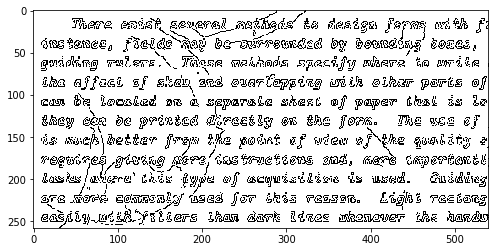

In [0]:
#%% #APPLY CANNY EDGE DETECTION

def edge(img,sigma = 0.33):
    v = np.median(img)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edge = cv2.Canny(img.astype(np.uint8), lower,upper)
    #edge = abs(edge-255)
    kernel = np.ones((1,1), np.uint8)*255
    morph = cv2.dilate(edge, kernel, iterations=1) 
    morph = cv2.erode(morph, kernel, iterations=2) 
    morph = cv2.dilate(morph, kernel, iterations=1) 
    morph = cv2.erode(morph, kernel, iterations=1) 
    morph = cv2.dilate(morph, kernel, iterations=1) 
    return abs(morph-255)

#x_train_edge = np.array([edge(img) for img in x_train])
#x_test_edge = np.array([edge(img) for img in x_test])
plt.imshow(x_train_edge[105],cmap='gray')

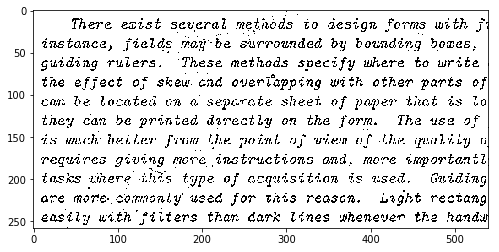

In [0]:
#%% #APPLY ADAPTIVE THRESHOLDING

def adapthresh(img, maxval=255, k=5, c=15):
     return cv2.adaptiveThreshold(img.astype(np.uint8), maxval, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, k, c)

#x_train_thresh = np.array([adapthresh(img) for img in x_train])
#x_test_thresh = np.array([adapthresh(img) for img in x_test])
plt.imshow(x_train_thresh[105],cmap='gray')

In [0]:
#%% #AUGMENT IMAGES

augpathx = r'%s' % dirpath + str('augmented_data/augpath_x/') 
print("Writing out to: " + augpathx)
if not os.path.exists(augpathx):
    os.makedirs(augpathx)
    
augpathy = r'%s' % dirpath + str('augmented_data/augpath_y/') 
print("Writing out to: " + augpathy)
if not os.path.exists(augpathy):
    os.makedirs(augpathy)

for i,(x,y) in enumerate(zip(x_train,y_train)):
    # Random cropping
    scale = random.random()
    scale = min(0.9, scale+0.3)
    cropped_x = x[:int(258*scale),:int(500*scale)]
    cropped_y = y[:int(258*scale),:int(500*scale)]
    cv2.imwrite(augpathx + 'cropped_'+str(i)+'.png', cropped_x)
    cv2.imwrite(augpathy + 'cropped_'+str(i)+'.png', cropped_y)
    
    # Rotations
    rotated_x = scipy.ndimage.rotate(x, 180)
    rotated_y = scipy.ndimage.rotate(y, 180)
    cv2.imwrite(augpathx + 'rotated_'+str(i)+'.png', rotated_x)
    cv2.imwrite(augpathy + 'rotated_'+str(i)+'.png', rotated_y)
    
    # Flips
    flip1_x = np.fliplr(x)
    flip1_y = np.fliplr(y)
    cv2.imwrite(augpathx + 'flip1_'+str(i)+'.png', flip1_x)
    cv2.imwrite(augpathy + 'flip1_'+str(i)+'.png', flip1_y)
    
    flip2_x = cv2.flip(x,0)
    flip2_y = cv2.flip(y,0)
    cv2.imwrite(augpathx + 'flip2_'+str(i)+'.png', flip2_x)
    cv2.imwrite(augpathy + 'flip2_'+str(i)+'.png', flip2_y)

Writing out to: /content/gdrive/My Drive/data/Denoising_Dirty_Documents/augmented_data/augpath_x/
Writing out to: /content/gdrive/My Drive/data/Denoising_Dirty_Documents/augmented_data/augpath_y/


(576, 258, 540, 1) (576, 258, 540, 1)


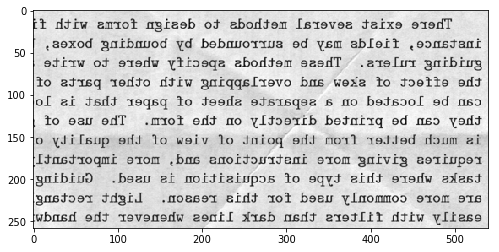

In [0]:
TRAIN_IMAGES_AUG = glob.glob(augpathx + '*.png')
CLEAN_IMAGES_AUG = glob.glob(augpathy + '*.png')

x_train_aug = load_image(TRAIN_IMAGES_AUG)#[:,:,:,0]
y_train_aug = load_image(CLEAN_IMAGES_AUG)#[:,:,:,0]

#plt.imshow(x_train_aug[0],cmap='gray')
print(x_train_aug.shape, y_train_aug.shape)

x_train_aug_example = load_image(TRAIN_IMAGES_AUG)[105,:,:,0]
plt.imshow(x_train_aug_example,cmap='gray')

In [0]:
#%% #PARTITION AUGMENTED DATA

def train_val_split(x_train, y_train):
    x_train = x_train/255.0
    y_train = y_train/255.0
    rnd = np.random.RandomState(seed=12345)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

xtrain, ytrain, xval, yval = train_val_split(x_train_aug, y_train_aug)
print(x_train.shape, y_train.shape)
print(xtrain.shape, xval.shape)

(144, 258, 540) (144, 258, 540)
(460, 258, 540) (116, 258, 540)


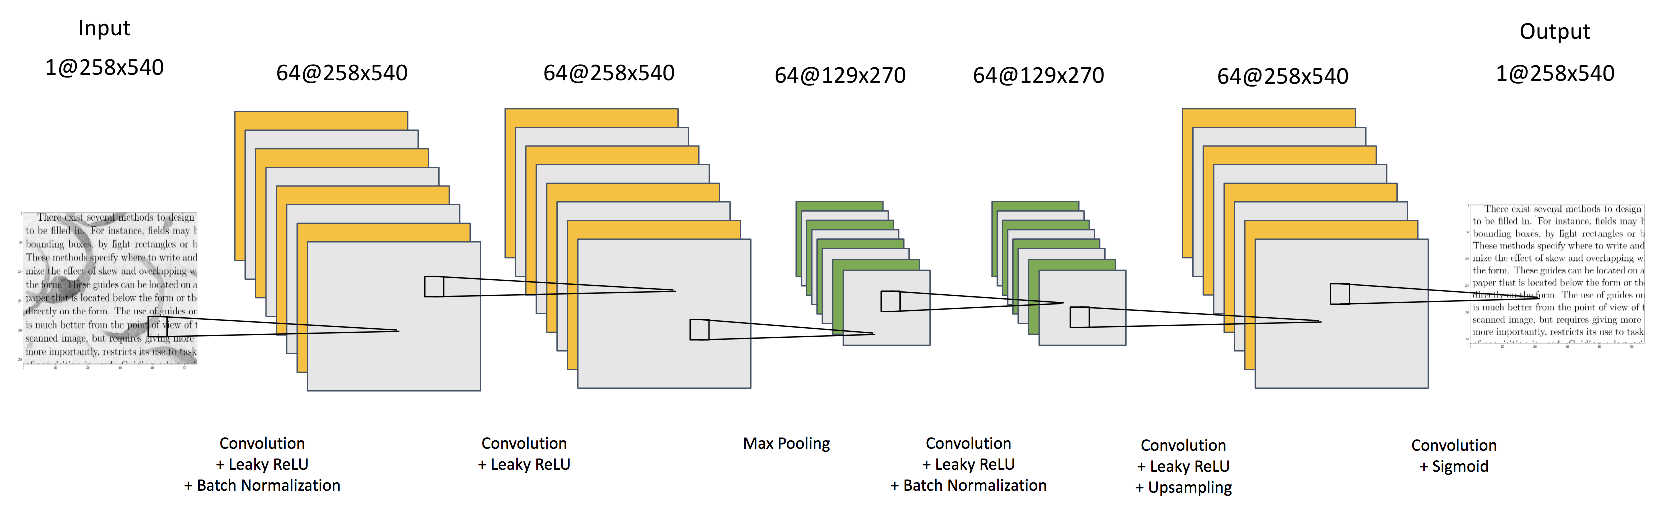

In [20]:
#%% #Display AE Architecture Used
Image(filename='/content/gdrive/My Drive/data/Denoising_Dirty_Documents/DDD_Autoencoder_Architecture.png')

In [0]:
#%% #DEFINE AUTOENCODER MODEL

class Autoencoder():
    def __init__(self):
        self.img_rows = 258
        self.img_cols = 540
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)        
        #optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)  
        optimizer = Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.005)   
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)        
        # encoder
        h = Conv2D(32, (3, 3), padding='same')(input_layer)
        h = ReLU(0.10)(h)
        h = BatchNormalization()(h)
        h = Conv2D(64, (3,3), padding='same')(h)
        h = ReLU(0.10)(h)
        h = MaxPooling2D((2, 2), padding='same')(h)        
        h = Conv2D(128, (3, 3),padding='same')(h)
        h = ReLU(0.10)(h)
        h = BatchNormalization()(h)
        # decoder
        h = Conv2D(128, (3, 3), padding='same')(h)
        h = ReLU(0.10)(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 258, 540, 32)      320       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 258, 540, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 258, 540, 32)      128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 258, 540, 64)      18496     
_________________________________________________________________
re_lu_14 (ReLU)              (None, 258, 540, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 129, 270, 64)      0         
__________

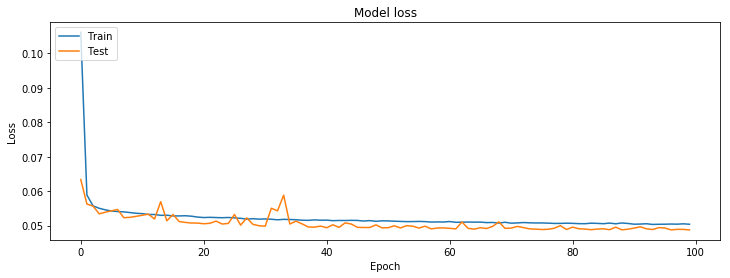

In [0]:
#%% #EXECUTE AE MODEL
AE = Autoencoder()
AE.train_model(xtrain, ytrain, xval, yval, epochs=100, batch_size=16)

In [0]:
x_train_cnn = AE.eval_model(x_train.reshape(144, 258, 540, 1)/255.0)[:,:,:,0]
#x_test_cnn = AE.eval_model(x_test.reshape(72, 258, 540, 1)/255.0)[:,:,:,0]

NameError: ignored

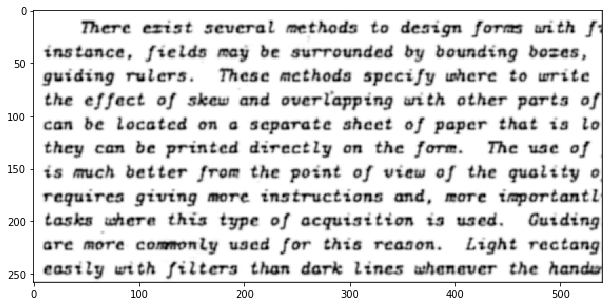

In [0]:
plt.figure(figsize = (20,5))
plt.imshow(x_train_cnn[105], cmap='gray')